<a href="https://colab.research.google.com/github/Samesh16/lpr/blob/master/comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ray gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 579.2 kB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [11]:
import ray
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gradio as gr
import time

In [4]:
ray.init()

2024-11-16 07:15:49,596	INFO worker.py:1819 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.39.0


In [19]:
def svd_sequential(channel):
    U, S, Vt = np.linalg.svd(channel, full_matrices=False)
    k = min(50, len(S))  # Use 50 singular values for reconstruction
    S = np.diag(S[:k])
    return np.dot(U[:, :k], np.dot(S, Vt[:k, :]))

In [13]:
@ray.remote
def svd_parallel(channel):
    return svd_sequential(channel)

In [20]:
def measure_sequential(image):
    start_time = time.time()
    channels = [image[:, :, i] for i in range(3)]
    processed_channels = [svd_sequential(ch) for ch in channels]
    gray_image = sum(processed_channels) / 3
    gray_image = (gray_image - gray_image.min()) / (gray_image.max() - gray_image.min()) * 255
    gray_image = gray_image.astype(np.uint8)
    end_time = time.time()
    return end_time - start_time

In [21]:
def measure_parallel(image):
    start_time = time.time()
    channels = [image[:, :, i] for i in range(3)]
    processed_channels = ray.get([svd_parallel.remote(ch) for ch in channels])
    gray_image = sum(processed_channels) / 3
    gray_image = (gray_image - gray_image.min()) / (gray_image.max() - gray_image.min()) * 255
    gray_image = gray_image.astype(np.uint8)
    end_time = time.time()
    return end_time - start_time

In [26]:
def compare_execution(image):
    # Resize image for testing large processing times
    image = cv2.resize(image, (2048, 2048))

    # Measure execution times
    sequential_time = measure_sequential(image)
    parallel_time = measure_parallel(image)

    # Print times
    print(f"Sequential Time: {sequential_time:.4f} seconds")
    print(f"Parallel Time: {parallel_time:.4f} seconds")

    # Plot comparison graph
    labels = ['Sequential', 'Parallel']
    times = [sequential_time, parallel_time]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, times, color=['blue', 'green'])
    plt.ylabel('Time (ms)')
    plt.title('Sequential vs Parallel Execution Time')
    plt.show()

In [27]:
image = cv2.imread("/content/3D-MRI-tumor-image-in-RGB-colored-form.png")
if image is None:
    raise FileNotFoundError("Image not found! Please check the file path.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Sequential Time: 29.5529 seconds
Parallel Time: 23.2254 seconds


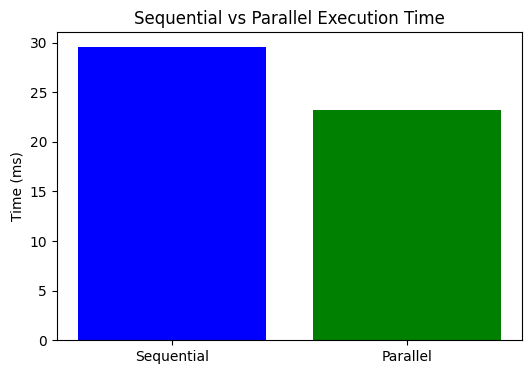

In [28]:
compare_execution(image)